In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,Dropout

import zipfile

import matplotlib.pyplot as plt
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d scolianni/mnistasjpg

zip_ref =zipfile.ZipFile("/content/mnistasjpg.zip", "r")
zip_ref.extractall("/content")
zip_ref.close()

#Keras helps with generators (divides in batches to save RAM)
#https://keras.io/api/data_loading/image/

 98% 67.0M/68.4M [00:04<00:00, 21.7MB/s]
100% 68.4M/68.4M [00:04<00:00, 16.0MB/s]


In [ ]:
#DATA
train_ds=keras.utils.image_dataset_from_directory(
    directory="/content/trainingSet/trainingSet",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(28, 28)
)

validation_ds=keras.utils.image_dataset_from_directory(
    directory="/content/trainingSample/trainingSample",
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(28, 28)
)


#CNN WITH SYNTAX

train_ds = train_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
model = Sequential()

model.add(Conv2D(filters=2, kernel_size=(5, 5), activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(filters=8, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))  # Change output units to 10 for 10 classes

#MODEL INFO
# model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=model.fit(train_ds, epochs=1, validation_data=validation_ds)


#IF WISH TO TEST!

# test_img = cv2.resize(cv2.imread("blah.jpeg", cv2.IMREAD_GRAYSCALE), (28, 28))
# # Reshape the image
# test_input = test_img.reshape(1, 28, 28, 1)
# # Predict using the model
# pred=model.predict(test_input)
# print(np.argmax(pred))

Found 42000 files belonging to 10 classes.
Found 600 files belonging to 10 classes.
1313/1313 [==============================] - 12s 7ms/step - loss: 0.6931 - accuracy: 0.8235 - val_loss: 0.1830 - val_accuracy: 0.9350


In [ ]:
def filter(image):
  # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rows, cols,c = image.shape
  if(c==3):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  padded=np.zeros((rows+4,cols+4));
  pool1=np.zeros((rows//2,cols//2));
  pool2=np.zeros((rows//2,cols//2));
  for i in range(rows):
    for j in range(cols):
      padded[i+2,j+2]=image[i,j]
  process = np.zeros((5, 5))
  temp = np.zeros((5, 5))
  fin1= np.zeros((rows, cols))
  fin2= np.zeros((rows, cols))

  #laplacian
  kernel1=[
      [1,4,7,4,1],
       [4,16,26,16,4],
        [7,26,41,26,7],
         [4,26,26,16,4],
          [1,4,7,4,1]
      ]
  bias1=1;

  #weighted average
  kernel2=[
      [0,0,-1,0,0],
       [0,-1,-2,-1,0],
        [-1,-2,16,-2,-1],
         [0,-1,-2,-1,0],
          [0,0,-1,0,0]
      ]
  bias2=1;
  def zero(val):
    if(val<0):
      return 0;
    else:
      return val;

  for i in range(4,rows):
      for j in range(4,cols):
        temp=padded[i-2:i+3,j-2:j+3];
        process=temp*kernel1;
        h=np.mean(process[0:4,0:4]);
        temp=bias1+h;
        fin1[i,j]=zero(temp);

  for i in range(4,rows):
    for j in range(4,cols):
      temp=padded[i-2:i+3,j-2:j+3];
      process=temp*kernel2;
      h=np.mean(process[0:4,0:4]);
      temp=bias2+h;
      fin2[i,j]=zero(temp);
  for i in range(0,cols,2):
    for j in range(0,rows,2):
      pool1[i//2, j//2] = np.max(fin1[i:i+2, j:j+2])
      pool2[i//2, j//2] = np.max(fin2[i:i+2, j:j+2])

  def sigmoid(x):
    return 1 / (1 + np.exp(-x))

  pool1pad=np.zeros((pool1.shape[0]+2,pool1.shape[1]+2));
  pool2pad=np.zeros((pool2.shape[0]+2,pool2.shape[1]+2));

  processed1=np.zeros((pool1.shape[0],pool1.shape[1]));
  processed2=np.zeros((pool2.shape[0],pool2.shape[1]));
  processed3=np.zeros((pool2.shape[0],pool2.shape[1]));
  processed4=np.zeros((pool2.shape[0],pool2.shape[1]));

  propool1=np.zeros((pool1.shape[0]//2,pool1.shape[1]//2));
  propool2=np.zeros((pool1.shape[0]//2,pool1.shape[1]//2));
  propool3=np.zeros((pool1.shape[0]//2,pool1.shape[1]//2));
  propool4=np.zeros((pool1.shape[0]//2,pool1.shape[1]//2));

  temp1= np.zeros((3, 3))
  for i in range(pool1.shape[0]):
    for j in range(pool1.shape[1]):
      pool1pad[i,j]=pool1[i,j];
      pool2pad[i,j]=pool2[i,j]

  pro1 =[[[-0.442,-0.124,-0.237],
        [-0.121,-0.207,-0.136],
        [0.104, 0.04, 0.207]],
         [[0.2, 0.011, 0.163],
          [0.019,-0.027, 0.178],
          [-0.172,-0.068, 0.037]]]
  pro1bias=-1.069;

  pro2 =[[[0.1,0.04,0.067],
        [-0.174,0.05,-0.063],
        [-0.025,-0.073,-0.248]],
       [[-0.075,0.217,0.155],
        [-0.134,0.068,0.114],
        [0.024,0.155,0.18]]]
  pro2bias=-2.87;

  pro3 =[[[-0.121,-0.114,-0.109],
        [0.238,0.273,0.007],
        [-0.065,0.0,0.102]],
       [[-0.036,-0.167,-0.04],
        [0.064,-0.025,-0.094],
        [0.478,0.113,-0.089]]]
  pro3bias=-2.963;

  pro4=[[[-0.022,-0.03,0.072],
       [0.113,0.095,-0.037],
       [0.067,-0.006,0.172]],
      [[-0.016,0.099,-0.688],
       [0.005,-0.157,-0.238],
       [-0.061,-0.13,-0.186]]]
  pro4bias=-0.212;

  for i in range(1, pool1.shape[0] - 1):
    for j in range(1, pool1.shape[1] - 1):
        temp1 = pool1pad[i - 1:i + 2, j - 1:j + 2]
        temp2 = pool2pad[i - 1:i + 2, j - 1:j + 2]
        processed1[i, j] = sigmoid((np.sum(temp1 * pro1[0]) +np.sum(temp2 * pro1[1]))+pro1bias);
        processed2[i, j] = sigmoid((np.sum(temp1 * pro2[0]) +np.sum(temp2 * pro2[1]))+pro2bias);
        processed3[i, j] = sigmoid((np.sum(temp1 * pro3[0]) +np.sum(temp2 * pro3[1]))+pro3bias);
        processed4[i, j] = sigmoid((np.sum(temp1 * pro4[0]) +np.sum(temp2 * pro4[1]))+pro4bias);


  for i in range(0,pool1.shape[1],2):
    for j in range(0,pool1.shape[0],2):
      propool1[i//2, j//2] = np.max(processed1[i:i+2, j:j+2])
      propool2[i//2, j//2] = np.max(processed2[i:i+2, j:j+2])
      propool3[i//2, j//2] = np.max(processed3[i:i+2, j:j+2])
      propool4[i//2, j//2] = np.max(processed4[i:i+2, j:j+2])

  fin_arr=(propool1.shape[1]*propool1.shape[0])*4;
  onerow=np.zeros((1,fin_arr));
  temp=0;
  for i in range(propool1.shape[1]):
    for j in range(propool1.shape[0]):
      onerow[0,temp]=propool1[i,j]
      temp=temp+1;
  for i in range(propool1.shape[1]):
    for j in range(propool1.shape[0]):
      onerow[0,temp]=propool2[i,j]
      temp=temp+1;
  for i in range(propool1.shape[1]):
    for j in range(propool1.shape[0]):
      onerow[0,temp]=propool3[i,j]
      temp=temp+1;
  for i in range(propool1.shape[1]):
    for j in range(propool1.shape[0]):
      onerow[0,temp]=propool4[i,j]
      temp=temp+1;
#Output at onerow
  return onerow;


In [ ]:
#196 points of one image

def train(model, maxbatch):
    temp = np.zeros(196)
    batch_counter = 0  # Counter to track the number of batches processed
    print('\n')
    print('TRAINING  [',end='', flush=True)
    for images, labels in train_ds:
        for image, label in zip(images, labels):
            if label == 0 or label == 1:
                print('-', end='-', flush=True)
                image_np = np.array(filter(image))
                model[label] = (model[label] + image_np[0]) / 2

        batch_counter += 1  # Increment the batch counter after processing each batch

        if batch_counter == maxbatch:
            print('> ] DONE!',end='', flush=True)
            break  # Break out of the loop after processing the specified number of batches

    print('\n')
    return model



def pred(image, model, out):
    def difference(a, b):
        out = np.zeros(196)
        for i in range(196):
            out[i] = abs(a[i] - b[i])
        return out.round(0)

    output = (np.array(filter(image))).round(3)
    for i in range(10):
        outside = difference(output[0], model[i])
        out[i] = outside
    return out

def check(image):
  out = np.zeros((10,196))
  pred(image, model, out)
  row_sums=np.zeros(10)
  a= np.sum(out, axis=1)
  return ( np.argmin(a) )

def acu(maxbatch):
    batch_counter = 0
    right = 0
    total = 0
    print('VALIDATING  [',end='', flush=True)
    for images, labels in validation_ds:
        for image, label in zip(images, labels):

            if label == 0 or label == 1:
                print('-', end='', flush=True)
                total += 1
                if label == check(image):
                    right += 1

        batch_counter += 1

        if batch_counter == maxbatch:
          print(' > ] DONE!',end='', flush=True)
          break

    print('\n')
    print("-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

    print("Total Images:", total)
    print("Right       :", right)
    accuracy = 100 * right / total if total != 0 else 0
    print("accuracy:", accuracy,"%")

    print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


In [ ]:
model = np.zeros((10, 196))

model=train(model,3)

acu(4)



TRAINING  [----

<ipython-input-12-84ea203cb11a>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


--------------------------------------------> ] DONE!

VALIDATING  [--------------------------- > ] DONE!

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Total Images: 27
Right       : 24
accuracy: 88.88888888888889 %
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
def filterExplain(image):
  rows, cols,c = image.shape
  if(c==3):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  padded=np.zeros((rows+4,cols+4));
  pool1=np.zeros((rows//2,cols//2));
  pool2=np.zeros((rows//2,cols//2));
  for i in range(rows):
    for j in range(cols):
      padded[i+2,j+2]=image[i,j]
  process = np.zeros((5, 5))
  temp = np.zeros((5, 5))
  fin1= np.zeros((rows, cols))
  fin2= np.zeros((rows, cols))

  #laplacian
  kernel1= [
      [0,0,-1,0,0],
       [0,-1,-2,-1,0],
        [-1,-2,16,-2,-1],
         [0,-1,-2,-1,0],
          [0,0,-1,0,0]
      ]
  bias1=1;

  #weighted average
  kernel2=[
      [1,4,7,4,1],
       [4,16,26,16,4],
        [7,26,41,26,7],
         [4,26,26,16,4],
          [1,4,7,4,1]
      ]
  bias2=1;
  def zero(val):
    if(val<0):
      return 0;
    else:
      return val;

  for i in range(4,rows):
      for j in range(4,cols):
        temp=padded[i-2:i+3,j-2:j+3];
        process=temp*kernel1;
        h=np.mean(process[0:4,0:4]);
        temp=bias1+h;
        fin1[i,j]=zero(temp);

  for i in range(4,rows):
    for j in range(4,cols):
      temp=padded[i-2:i+3,j-2:j+3];
      process=temp*kernel2;
      h=np.mean(process[0:4,0:4]);
      temp=bias2+h;
      fin2[i,j]=zero(temp);
  for i in range(0,cols,2):
    for j in range(0,rows,2):
      pool1[i//2, j//2] = np.max(fin1[i:i+2, j:j+2])
      pool2[i//2, j//2] = np.max(fin2[i:i+2, j:j+2])

  def sigmoid(x):
    return 1 / (1 + np.exp(-x))

  pool1pad=np.zeros((pool1.shape[0]+2,pool1.shape[1]+2));
  pool2pad=np.zeros((pool2.shape[0]+2,pool2.shape[1]+2));

  processed1=np.zeros((pool1.shape[0],pool1.shape[1]));
  processed2=np.zeros((pool2.shape[0],pool2.shape[1]));
  processed3=np.zeros((pool2.shape[0],pool2.shape[1]));
  processed4=np.zeros((pool2.shape[0],pool2.shape[1]));

  propool1=np.zeros((pool1.shape[0]//2,pool1.shape[1]//2));
  propool2=np.zeros((pool1.shape[0]//2,pool1.shape[1]//2));
  propool3=np.zeros((pool1.shape[0]//2,pool1.shape[1]//2));
  propool4=np.zeros((pool1.shape[0]//2,pool1.shape[1]//2));

  temp1= np.zeros((3, 3))
  for i in range(pool1.shape[0]):
    for j in range(pool1.shape[1]):
      pool1pad[i,j]=pool1[i,j];
      pool2pad[i,j]=pool2[i,j]

#Edge Detector - Standard
#This filter seems to be designed to detect edges or changes in intensity. The negative values in the filter suggest it's looking for transitions from light to dark areas or vice versa.
#The first kernel captures horizontal edges, while the second kernel captures vertical edges.
#The bias term (pro1bias) suggests that this filter might be sensitive to features that are relatively sparse in the image.

  pro1 =[[[-0.442,-0.124,-0.237],
        [-0.121,-0.207,-0.136],
        [0.104, 0.04, 0.207]],
         [[0.2, 0.011, 0.163],
          [0.019,-0.027, 0.178],
          [-0.172,-0.068, 0.037]]]
  pro1bias=-1.069;


#Edge Detector - Enhanced"
# This filter also seems to be aimed at edge detection, but with slightly different characteristics compared to Filter 1.
# The positive and negative values in the filter indicate it's looking for changes in intensity as well.
# Like Filter 1, it has two kernels, one for horizontal edges and the other for vertical edges.
# The bias term (pro2bias) suggests similar sensitivity to sparse features in the image.

  pro2 =[[[0.1,0.04,0.067],
        [-0.174,0.05,-0.063],
        [-0.025,-0.073,-0.248]],
       [[-0.075,0.217,0.155],
        [-0.134,0.068,0.114],
        [0.024,0.155,0.18]]]
  pro2bias=-2.87;

#Corner and Junction Detector
# This filter appears to be sensitive to corners or junctions in the image. It has elements that are positive and negative, capturing changes in intensity in multiple directions.
# The kernels in this filter might detect corners, edges meeting at different angles, or T-junctions.
# The bias term (pro3bias) indicates a similar sensitivity to sparse features.

  pro3 =[[[-0.121,-0.114,-0.109],
        [0.238,0.273,0.007],
        [-0.065,0.0,0.102]],
       [[-0.036,-0.167,-0.04],
        [0.064,-0.025,-0.094],
        [0.478,0.113,-0.089]]]
  pro3bias=-2.963;

#Texture and Pattern Detector
# This filter seems to focus on texture or pattern detection rather than just edges or corners.
# The elements in the kernels do not strictly alternate between positive and negative, suggesting it's looking for patterns that might not just involve abrupt intensity changes.
# It might detect textures such as grids, fabrics, or repetitive patterns in the image.
# The bias term (pro4bias) suggests sensitivity to specific textures or patterns.

  pro4=[[[-0.022,-0.03,0.072],
       [0.113,0.095,-0.037],
       [0.067,-0.006,0.172]],
      [[-0.016,0.099,-0.688],
       [0.005,-0.157,-0.238],
       [-0.061,-0.13,-0.186]]]
  pro4bias=-0.212;

  for i in range(1, pool1.shape[0] - 1):
    for j in range(1, pool1.shape[1] - 1):
        temp1 = pool1pad[i - 1:i + 2, j - 1:j + 2]
        temp2 = pool2pad[i - 1:i + 2, j - 1:j + 2]
        processed1[i, j] = sigmoid((np.sum(temp1 * pro1[0]) +np.sum(temp2 * pro1[1]))+pro1bias);
        processed2[i, j] = sigmoid((np.sum(temp1 * pro2[0]) +np.sum(temp2 * pro2[1]))+pro2bias);
        processed3[i, j] = sigmoid((np.sum(temp1 * pro3[0]) +np.sum(temp2 * pro3[1]))+pro3bias);
        processed4[i, j] = sigmoid((np.sum(temp1 * pro4[0]) +np.sum(temp2 * pro4[1]))+pro4bias);


  for i in range(0,pool1.shape[1],2):
    for j in range(0,pool1.shape[0],2):
      propool1[i//2, j//2] = np.max(processed1[i:i+2, j:j+2])
      propool2[i//2, j//2] = np.max(processed2[i:i+2, j:j+2])
      propool3[i//2, j//2] = np.max(processed3[i:i+2, j:j+2])
      propool4[i//2, j//2] = np.max(processed4[i:i+2, j:j+2])



  fin_arr=(propool1.shape[1]*propool1.shape[0])*4;
  onerow=np.zeros((1,fin_arr));
  temp=0;
  for i in range(propool1.shape[1]):
    for j in range(propool1.shape[0]):
      onerow[0,temp]=propool1[i,j]
      temp=temp+1;
  for i in range(propool1.shape[1]):
    for j in range(propool1.shape[0]):
      onerow[0,temp]=propool2[i,j]
      temp=temp+1;
  for i in range(propool1.shape[1]):
    for j in range(propool1.shape[0]):
      onerow[0,temp]=propool3[i,j]
      temp=temp+1;
  for i in range(propool1.shape[1]):
    for j in range(propool1.shape[0]):
      onerow[0,temp]=propool4[i,j]
      temp=temp+1;
#Output at onerow
#all 4 image data in one row

  plt.figure(figsize=(15,15))

  plt.subplot(5, 4, 1)
  plt.imshow(image,cmap="gray")
  plt.title('original image')
  plt.axis(False)

  plt.subplot(5, 4, 2)
  plt.imshow(fin1,cmap="gray")
  plt.title('laplacian filter')
  plt.axis(False)

  plt.subplot(5, 4, 3)
  plt.imshow(fin2,cmap="gray")
  plt.title('Averaging filter')
  plt.axis(False)

  plt.subplot(5, 4, 6)
  plt.imshow(pool1,cmap="gray")
  plt.title('Laplacian filter pooled')
  plt.axis(False)

  plt.subplot(5, 4, 7)
  plt.imshow(pool2,cmap="gray")
  plt.title('Averaging pooled')
  plt.axis(False)
  print(pool2.shape)

  plt.subplot(5, 4, 9)
  plt.imshow(processed1,cmap="gray")
  plt.title('Edge Detector - Standard')
  plt.axis(False)



  plt.subplot(5, 4, 10)
  plt.imshow(processed2,cmap="gray")
  plt.title('Edge Detector - Enhanced')
  plt.axis(False)

  plt.subplot(5, 4, 11)
  plt.imshow(processed3,cmap="gray")
  plt.title('Corner and Junction Detector')
  plt.axis(False)

  plt.subplot(5, 4, 12)
  plt.imshow(processed4,cmap="gray")
  plt.title('Texture and Pattern Detector')
  plt.axis(False)

  plt.subplot(5, 4, 13)
  plt.imshow(propool1,cmap="gray")
  plt.title('Pooled')
  plt.axis(False)



  plt.subplot(5, 4, 14)
  plt.imshow(propool2,cmap="gray")
  plt.title('Pooled')
  plt.axis(False)

  plt.subplot(5, 4, 15)
  plt.imshow(propool3,cmap="gray")
  plt.title('Pooled')
  plt.axis(False)

  print(propool4.shape)

  plt.subplot(5, 4, 16)
  plt.imshow(propool4,cmap="gray")
  plt.title('Pooled')
  plt.axis(False)

  print(onerow.shape)
  # plt.subplot(5, 4, 18)
  # plt.imshow(onerow,cmap="gray")
  # plt.title('Output Image')
  # plt.axis(False)
  return onerow;



(14, 14)


<ipython-input-7-e359163a3810>:62: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


(7, 7)
(1, 196)


<ipython-input-4-5316ff1f7825>:66: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0

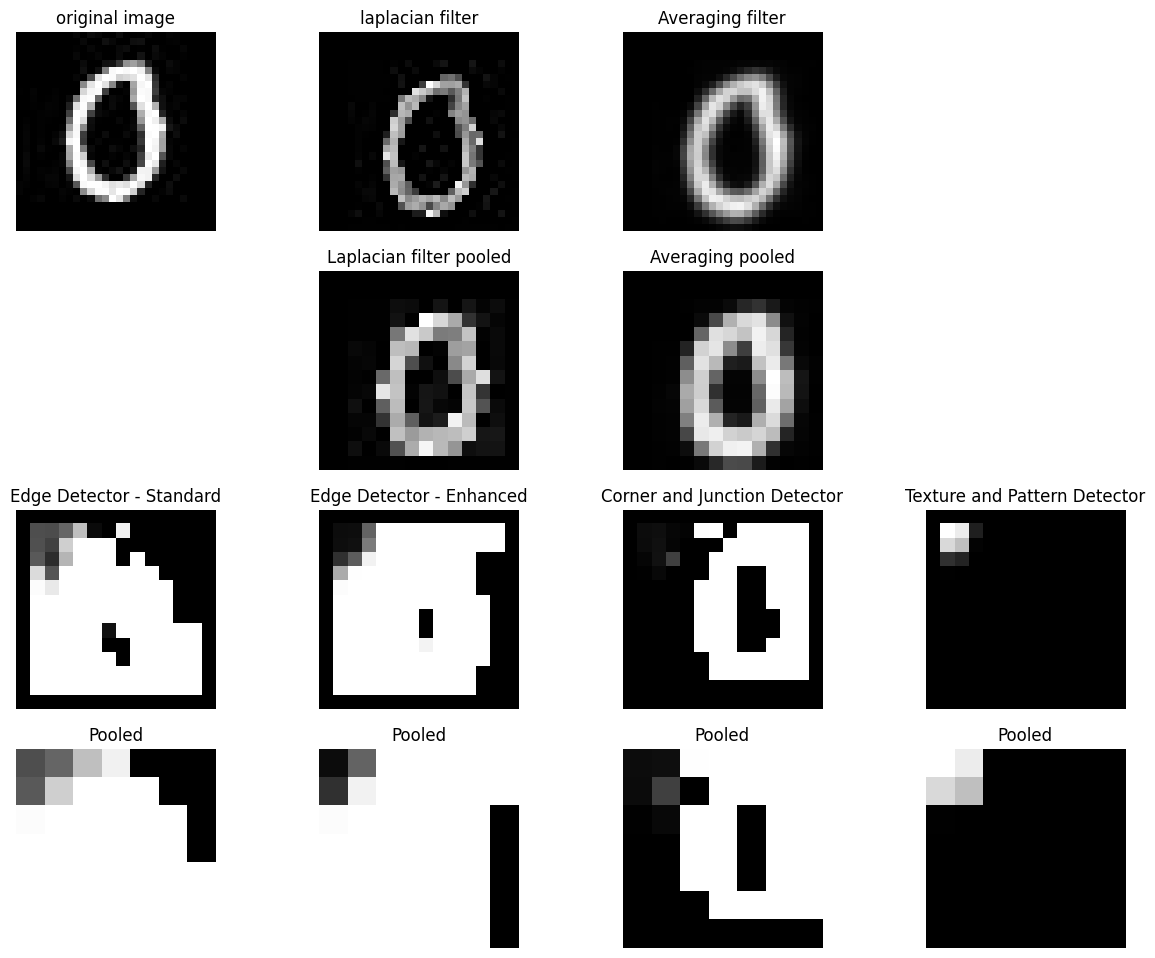

In [ ]:
image=(cv2.imread('0.jpg'))
c=filterExplain(image)
check(image)

In [ ]:
print("OUTPUT IMAGE")
plt.figure(figsize=(30,30))
plt.imshow(c,cmap="gray")
plt.axis(False)

OUTPUT IMAGE


(-0.5, 195.5, 0.5, -0.5)

In [ ]:
check(image)

<ipython-input-4-5316ff1f7825>:66: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0

In [ ]:
image1=(cv2.imread('0.jpg'))
check(image1)

<ipython-input-12-84ea203cb11a>:64: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0